In [1]:
import pandas as pd
import requests
import json
import datetime as dt
import os
import plotly as plt
import tensorflow as tf
import keras
import numpy as np
import pyod
from pyod.models.ecod import ECOD
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
import time
import plotly.express as px
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn import metrics
from numpy import percentile
# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP
from pyod.models.inne import INNE
from pyod.models.gmm import GMM
from pyod.models.kde import KDE
from pyod.models.lmdd import LMDD

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, accuracy_score


# Diagram of Actions <br>
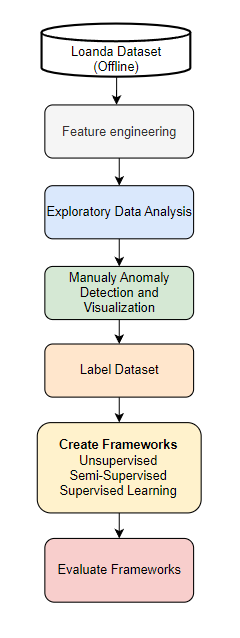

# Loanda Dataset <br>
Real Dataset from Loanda, Paraná, Brazil.

Os dados estão na pasta data/loandas/generation_data. Os dados foram particionados em json.

In [2]:
json_file_path = 'C:/Users/EMC/Documents/doutorado/doctorade/data/loanda/generation_data/'

os.listdir(json_file_path)

['loanda_data_curated_0.json',
 'loanda_data_curated_200000.json',
 'loanda_data_curated_400000.json',
 'loanda_data_curated_600000.json',
 'loanda_data_curated_800000.json']

# Weather Data<br>
https://open-meteo.com/en/docs/historical-weather-api#start_date=2021-07-01&end_date=2023-10-17&hourly=temperature_2m,relativehumidity_2m,precipitation,weathercode,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,is_day,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,terrestrial_radiation,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,terrestrial_radiation_instant&daily=weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,precipitation_sum,rain_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration&timezone=America%2FSao_Paulo

In [3]:
json_file_path = 'C:/Users/EMC/Documents/doutorado/doctorade/data/loanda/weather_data/'

os.listdir(json_file_path)

['loanda_weather.json', 'loanda_weather_curated.json']

# Load Data

In [4]:
# Weather Data
path = 'C:/Users/EMC/Documents/doutorado/doctorade/data/loanda/weather_data/loanda_weather_curated.json'
with open(path, "r") as json_file:
# Load the JSON data into a Python object.
    json_data = json.load(json_file)
    df_weather = pd.DataFrame.from_dict(json_data)

df_weather = df_weather[['time_in_iso8601','is_day_in_']].sort_values(by='time_in_iso8601')

df_weather[['time_in_iso8601','is_day_in_']].sort_values(by='time_in_iso8601')

# Loanda Data
json_file_path = 'C:/Users/EMC/Documents/doutorado/doctorade/data/loanda/generation_data/'
df_generation = pd.DataFrame()
for data_chunks in os.listdir(json_file_path):
    path = json_file_path + data_chunks
    with open(path, "r") as json_file:
    # Load the JSON data into a Python object.
        json_data = json.load(json_file)
        pd_json_data = pd.DataFrame.from_dict(json_data)
        df_generation = pd.concat([df_generation,pd_json_data])

df = df_generation.drop_duplicates()
# Find None
df = df.replace('nan', None)
# To Datetime
df['E3TimeStamp'] = pd.to_datetime(df['E3TimeStamp'], format = 'mixed')

df_time = df[['E3TimeStamp']]

df_float = df[['PotenciaAtivaTotal', 'EnergiaTotal_DataLogger',
       'EnergiaDiaria_DataLogger', 'RadiacaoGlobal', 'TempAr', 'TempModulo',
       'VelocidadeVento', 'EnergiaTotal_LoteB', 'EnergiaDiaria_LoteB',
       'EnergiaReativa_LoteB', 'EnergiaTotal_LoteC', 'EnergiaDiaria_LoteC',
       'EnergiaReativa_LoteC', 'EnergiaTotal_LoteD', 'EnergiaDiaria_LoteD',
       'EnergiaReativa_LoteD', 'EnergiaTotal_LoteE', 'EnergiaDiaria_LoteE',
       'EnergiaReativa_LoteE', 'EnergiaTotal_LoteF', 'EnergiaDiaria_LoteF',
       'EnergiaReativa_LoteF']].astype(float)

df = pd.concat([df_time,df_float], axis = 1)

df = df[df['E3TimeStamp'] < '2023/06/01']

df = df.sort_values(by='E3TimeStamp')

# Exploratory Data Analysis I

## Generation Data

In [5]:
try:
  df = df.set_index('E3TimeStamp')
except:
  pass
try:
  del df['YMDH']
except:
  pass
try:
  del df['is_day_in_']
except:
  pass


df_descricao = pd.DataFrame()

df_descricao['No_None_Values_Count'] = round(df.apply(lambda x: x.count()),2)
df_descricao['None_Values_Count'] = round(df.apply(lambda x: x.isnull().sum()),2)
df_descricao['Zeroes_Values_Count'] = round(df.apply(lambda x: (x == 0).sum()),2)
df_descricao['Min_Values'] = round(df.apply(lambda x: x.min()),2)
df_descricao['Max_Values'] = round(df.apply(lambda x: x.max()),2)
df_descricao['Mean_Values'] = round(df.apply(lambda x: x.mean()),2)
df_descricao['Std_Values'] = round(df.apply(lambda x: x.std()),2)
df_descricao['Sum of Values'] = round(df.apply(lambda x: x.sum()),0)
# df_descricao['Min_Date'] = df.index.min()
# df_descricao['Max_Date'] = df.index.max()
df_descricao

,No_None_Values_Count,None_Values_Count,Zeroes_Values_Count,Min_Values,Max_Values,Mean_Values,Std_Values,Sum of Values,Min_Date,Max_Date
PotenciaAtivaTotal,942290,0,476124,0.00,5040.00,1024.94,1563.29,9.657880e+08,2021-08-04 10:52:11.727,2023-05-31 23:59:46.353
EnergiaTotal_DataLogger,942290,0,108338,0.00,16809379.00,4842305.19,4801862.34,4.562856e+12,2021-08-04 10:52:11.727,2023-05-31 23:59:46.353
EnergiaDiaria_DataLogger,942290,0,245882,0.00,43244.00,8868.45,10104.20,8.356656e+09,2021-08-04 10:52:11.727,2023-05-31 23:59:46.353
RadiacaoGlobal,939172,3118,36497,-20.00,1650.00,221.60,326.77,2.081192e+08,2021-08-04 10:52:11.727,2023-05-31 23:59:46.353
TempAr,939172,3118,7482,-10.00,195.00,23.81,6.87,2.236432e+07,2021-08-04 10:52:11.727,2023-05-31 23:59:46.353
TempModulo,939172,3118,7482,-10.00,197.00,26.61,15.77,2.499448e+07,2021-08-04 10:52:11.727,2023-05-31 23:59:46.353
VelocidadeVento,939172,3118,178749,-10.00,58.00,0.78,3.89,7.372440e+05,2021-08-04 10:52:11.727,2023-05-31 23:59:46.353
EnergiaTotal_LoteB,858841,83449,20910,0.00,3974923.90,2253632.15,1031255.84,1.935512e+12,2021-08-04 10:52:11.727,2023-05-31 23:59:46.353
EnergiaDiaria_LoteB,858841,83449,153233,0.00,8733.70,3460.64,2831.78,2.972136e+09,2021-08-04 10:52:11.727,2023-05-31 23:59:46.353
EnergiaReativa_LoteB,858841,83449,428308,-60.06,41.35,0.71,3.76,6.115840e+05,2021-08-04 10:52:11.727,2023-05-31 23:59:46.353


## Weather Data

In [6]:
df_weather['is_day_in_'] = df_weather['is_day_in_'].astype(float)
try:
  df_weather = df_weather.set_index('time_in_iso8601')
except:
  pass
try:
  del df_weather['YMDH']
except:
  pass

df_descricao = pd.DataFrame()

df_descricao['No_None_Values_Count'] = round(df_weather.apply(lambda x: x.count()),2)
df_descricao['None_Values_Count'] = round(df_weather.apply(lambda x: x.isnull().sum()),2)
df_descricao['Zeroes_Values_Count'] = round(df_weather.apply(lambda x: (x == 0).sum()),2)
df_descricao['Min_Values'] = round(df_weather.apply(lambda x: x.min()),2)
df_descricao['Max_Values'] = round(df_weather.apply(lambda x: x.max()),2)
df_descricao['Mean_Values'] = round(df_weather.apply(lambda x: x.mean()),2)
df_descricao['Std_Values'] = round(df_weather.apply(lambda x: x.std()),2)
df_descricao['Sum of Values'] = round(df_weather.apply(lambda x: x.sum()),0)
# df_descricao['Min_Date'] = df_weather.index.min()
# df_descricao['Max_Date'] = df_weather.index.max()
df_descricao

,No_None_Values_Count,None_Values_Count,Zeroes_Values_Count,Min_Values,Max_Values,Mean_Values,Std_Values,Sum of Values,Min_Date,Max_Date
is_day_in_,19629,0,9734,0.0,1.0,0.5,0.5,9895.0,2021-07-16 00:00:00,2023-10-11 20:00:00


In [7]:
fig = plt.plot(x = pd.to_datetime(df_weather.reset_index()['time_in_iso8601']).dt.hour,y= df_weather['is_day_in_'], data_frame=df_weather, kind='hist')
fig.update_layout(
    title='Distribution of Hours in the Day',
    xaxis=dict(title='Hour of the Day'),
    yaxis=dict(title='Frequency')
)

# Feature Engineering

Data cleaning was conducted by removing null records indicating periods when production had not yet commenced. As we aim to predict the solar energy generation we are going to use only daylight information (while sun is up) using Weather dataset information. For each production batch, the variable yX was created to represent production per minute. This variable was derived from the Daily Energy variable, which records the cumulative total of generated energy. The purpose of this approach is to ensure a more accurate and detailed representation of production per batch by eliminating irrelevant or non-applicable data during periods when actual production was not taking place. The column names were translated from Portuguese to English.

In [8]:
# Create Year Month Date Hour
df_weather['YMDH']= pd.to_datetime(df_weather.reset_index()['time_in_iso8601']).dt.strftime('%Y%m%d%H').values

# Create Year Month Date Hour
df['YMDH'] = df.reset_index()['E3TimeStamp'].dt.strftime('%Y%m%d%H').values
# Set timestamp as index
try:
    df = df.set_index('E3TimeStamp')
except:
    pass

# Fix data in the begining of the day
df_copy = df.copy()
daily_energy_list = ['EnergiaDiaria_LoteB','EnergiaDiaria_LoteC','EnergiaDiaria_LoteD','EnergiaDiaria_LoteE','EnergiaDiaria_LoteF']
df_copy['YMD'] = df_copy.reset_index()['E3TimeStamp'].dt.strftime('%Y%m%d').values
for column in daily_energy_list:
    last_value_day_before = df_copy[df_copy['YMD'] == df_copy['YMD'].min()][column][-1]
    for day in sorted(list(set(df_copy['YMD']))):
        df_day = df_copy[df_copy['YMD'] == day]
        if ((df_day[column][0] == last_value_day_before) and (df_day[column][0] != 0)):
            try: 
                df.loc[df_day.loc[:df_day[df_day[column].shift(-1).diff().lt(0)].index[0], column].index, column] = 0
            except:
                df.loc[df_day.index,column] = 0
        last_value_day_before = df_day[column][-1]

# Create Yx variable with t - (t-1)
df['yB'] = df.EnergiaDiaria_LoteB.diff().shift(-1)
df['yC'] = df.EnergiaDiaria_LoteC.diff().shift(-1)
df['yD'] = df.EnergiaDiaria_LoteD.diff().shift(-1)
df['yE'] = df.EnergiaDiaria_LoteE.diff().shift(-1)
df['yF'] = df.EnergiaDiaria_LoteF.diff().shift(-1)

# Translate Columns
df.columns = ['ActivePowerTotal', 'TotalEnergy_DataLogger',
              'DailyEnergy_DataLogger', 'GlobalRadiation', 'AirTemperature', 'ModuleTemperature',
              'WindSpeed', 'TotalEnergy_B', 'DailyYield_B (KW)',
              'ReactiveEnergy_B', 'TotalEnergy_C', 'DailyYield_C (KW)',
              'ReactiveEnergy_C', 'TotalEnergy_D', 'DailyYield_D (KW)',
              'ReactiveEnergy_D', 'TotalEnergy_E', 'DailyYield_E (KW)',
              'ReactiveEnergy_E', 'TotalEnergy_F', 'DailyYield_F (KW)',
              'ReactiveEnergy_F', 'YMDH','AC_Power_B (KW)', 'AC_Power_C (KW)', 'AC_Power_D (KW)', 'AC_Power_E (KW)', 'AC_Power_F (KW)']
# Delete Null Values
df = df[~(df['AC_Power_F (KW)'].isna())]

# Merge with weather data and filter only is_day_in = 1
df = df.reset_index().merge(df_weather[['is_day_in_','YMDH']], how = 'left', on = 'YMDH').set_index('E3TimeStamp')
df = df[df['is_day_in_'] == 1]
df = df[['GlobalRadiation', 'AirTemperature',
       'WindSpeed','DailyYield_B (KW)','AC_Power_B (KW)']]

df = df.reset_index()[df.reset_index()['E3TimeStamp'].dt.year == 2022].set_index('E3TimeStamp')

# Exploratory Data Analysis II

In [9]:
try:
  df = df.set_index('E3TimeStamp')
except:
  pass
try:
  del df['YMDH']
except:
  pass
try:
  del df['is_day_in_']
except:
  pass


df_descricao = pd.DataFrame()

df_descricao['No_None_Values_Count'] = round(df.apply(lambda x: x.count()),2)
df_descricao['None_Values_Count'] = round(df.apply(lambda x: x.isnull().sum()),2)
df_descricao['Zeroes_Values_Count'] = round(df.apply(lambda x: (x == 0).sum()),2)
df_descricao['Min_Values'] = round(df.apply(lambda x: x.min()),2)
df_descricao['Max_Values'] = round(df.apply(lambda x: x.max()),2)
df_descricao['Mean_Values'] = round(df.apply(lambda x: x.mean()),2)
df_descricao['Std_Values'] = round(df.apply(lambda x: x.std()),2)
df_descricao['Sum of Values'] = round(df.apply(lambda x: x.sum()),0)
df_descricao['Min_Date'] = df.index.min()
df_descricao['Max_Date'] = df.index.max()
df_descricao

,No_None_Values_Count,None_Values_Count,Zeroes_Values_Count,Min_Values,Max_Values,Mean_Values,Std_Values,Sum of Values,Min_Date,Max_Date
GlobalRadiation,261887,0,2801,-20.0,1650.0,420.65,329.28,110162957.0,2022-01-01 06:00:33.077,2022-12-31 19:59:03.667
AirTemperature,261887,0,1545,0.0,154.0,26.01,6.61,6812211.0,2022-01-01 06:00:33.077,2022-12-31 19:59:03.667
WindSpeed,261887,0,17197,-10.0,16.0,0.46,5.00,120550.0,2022-01-01 06:00:33.077,2022-12-31 19:59:03.667
DailyYield_B (KW),261887,0,11499,0.0,8635.4,3159.75,2496.85,827498083.0,2022-01-01 06:00:33.077,2022-12-31 19:59:03.667
AC_Power_B (KW),261887,0,38675,-8026.6,8027.3,7.68,93.44,2010834.0,2022-01-01 06:00:33.077,2022-12-31 19:59:03.667


In [10]:
# Correlation
df_corr = df[['AirTemperature', 
       'WindSpeed','DailyYield_B (KW)','AC_Power_B (KW)']].corr().round(2)
fig = px.imshow(df_corr, text_auto=True, aspect="auto")
# Update layout to increase font size
fig.update_layout(
    font=dict(size=22),  # Adjust the font size
    xaxis=dict(title="Features", tickangle=-45),
    yaxis=dict(title="Features"),
)

# Manualy Anomaly Detection and Visualization for DailyYield B, AC_Power_B, Air Temperature, Module Temperature, WindSpeed

In [11]:
df_analysis = df[['GlobalRadiation', 'AirTemperature','WindSpeed','DailyYield_B (KW)','AC_Power_B (KW)']]

Point Anomaly:<br>
A point anomaly is defined as a single data point that is unusual compared to the rest of the data. A single balmy day in an otherwise chilly winter would be a good example of this.
On that day, the weather is considered anomalous because the temperature is extreme compared to the rest of the season. Point anomalies often occur in this way, as a singular extreme value on a single attribute of the data.

Contextual Anomaly:<br>
Also called conditional outliers, contextual anomalies contain data points that significantly deviate from the other data points that exist in the same context. An anomaly in the context of one dataset may not be an anomaly in another.
For instance, one of your customers may double their usual spending behavior in mid-December for the holiday season. These outliers are common in time series data because those datasets are records of specific quantities for given periods.

Collective anomaly:<br>
A collective anomaly is a collection of similar data points that can be considered abnormal together when compared to the rest of the data.
For example, a consecutive 10-day period of hot temperatures could be considered a collective anomaly.
These temperatures are unusual because they occur together and are likely caused by the same underlying weather event.

## Point Anomaly

### Daily Yield

The Daily Energy variable is designed to exhibit a consistent daily growth pattern. It starts with an initial value of 0 and experiences continuous minute-by-minute energy generation throughout the day, reaching its peak before resetting to 0 at the day's end. A visual representation of this behavior in the plot highlights an anomaly in the data, particularly during the midday period. During this timeframe, the data logger records values of Daily Energy (t) that are lower than the preceding timestamp (t-1), suggesting a potential anomaly stemming from either the data logger itself or the underlying database.

In [12]:
df_periodo = df_analysis[(df_analysis.index >= '2022-11-13') & (df_analysis.index < '2022-11-15')]
fig = plt.plot(x = df_periodo.index,y= [df_periodo['DailyYield_B (KW)']], data_frame=df_periodo, kind='line')
fig.update_layout(font=dict(size=22),  # Adjust the font size
xaxis=dict(title="Datetime"),
yaxis=dict(title="KW"))

### AC Power B
The variable yX is derived from the daily energy measurement, representing the energy production per minute. Within the time series, we can identify point anomalies, with instances where the values turn negative serving as indicators of potential issues in the data logger associated with the Daily Energy information.

In [13]:
df_periodo = df_analysis[(df_analysis.index >= '2022-11-13') & (df_analysis.index < '2022-11-15')]
fig = plt.plot(x = df_periodo.index,y= [df_periodo['AC_Power_B (KW)']], data_frame=df_periodo, kind='line')
fig.update_layout(font=dict(size=22),  # Adjust the font size
xaxis=dict(title="Datetime"),
yaxis=dict(title="KW"))

### Global Radiation
Examine anomalies in global radiation, particularly sudden drops throughout the day and isolated zero values. These significant variations may indicate potential issues in the measurement system or data acquisition, necessitating a more in-depth investigation to ensure the accuracy and reliability of global radiation information.

In [14]:
df_periodo = df_analysis[(df.index >= '2022-08-09') & (df_analysis.index < '2022-08-18')]
plt.plot(x = df_periodo.index,y= [df_periodo['GlobalRadiation']], data_frame=df_periodo, kind='line')

## Collective Anomaly

### Air Temperature and Module Temperature
Examine anomalous readings in the air temperature and tempModulo data logger, specifically focusing on maximum temperatures reaching 195 degrees observed in the EDA section. Notably, there are extremely high temperatures recorded during nighttime periods, suggesting potential anomalies that warrant investigation.

In [15]:
df_analysis[df_analysis.AirTemperature > 50.0]

,GlobalRadiation,AirTemperature,WindSpeed,DailyYield_B (KW),AC_Power_B (KW)
E3TimeStamp,,,,,
2022-05-18 14:44:48.840,308.0,54.0,-10.0,2585.4,7.5
2022-05-18 14:46:48.763,428.0,60.0,-10.0,2597.4,9.0
2022-05-18 14:47:48.780,160.0,62.0,-10.0,2606.4,5.8
2022-05-18 14:48:48.773,465.0,74.0,-10.0,2612.2,14.2
2022-05-18 14:49:48.750,621.0,70.0,-10.0,2626.4,10.8
...,...,...,...,...,...
2022-05-19 11:15:48.753,252.0,91.0,-10.0,1519.2,6.8
2022-05-19 11:16:48.757,274.0,91.0,-10.0,1526.0,7.2
2022-05-19 11:28:48.847,277.0,54.0,-10.0,1624.9,8.7


In [16]:
df_periodo = df_analysis[(df_analysis.index >= '2022-05-18') & (df_analysis.index < '2022-05-22')]
fig = plt.plot(x = df_periodo.index,y= [df_periodo['AirTemperature']], data_frame=df_periodo, kind='line')

fig.update_layout(font=dict(size=22),  # Adjust the font size
xaxis=dict(title="Datetime"),
yaxis=dict(title="Cº"))

### Wind Speed
Anomalies in wind speed readings, especially when they remain consistently at -10, can be indicative of measurement errors, instrument malfunction, or data transmission issues. Wind speed is typically measured in positive values, and sustained negative readings are not physically meaningful in the context of standard wind speed measurements.

In [17]:
df_analysis[df_analysis.WindSpeed < 0]

,GlobalRadiation,AirTemperature,WindSpeed,DailyYield_B (KW),AC_Power_B (KW)
E3TimeStamp,,,,,
2022-03-22 10:59:55.207,871.0,28.0,-10.0,2672.3,15.9
2022-03-22 11:00:55.303,893.0,28.0,-10.0,2688.2,17.3
2022-03-22 11:01:55.207,940.0,28.0,-10.0,2705.5,16.4
2022-03-22 11:02:55.177,1062.0,28.0,-10.0,2721.9,16.6
2022-03-22 11:03:55.187,1056.0,28.0,-10.0,2738.5,16.3
...,...,...,...,...,...
2022-05-26 14:51:48.810,511.0,28.0,-10.0,4375.5,10.0
2022-05-26 14:52:48.950,396.0,28.0,-10.0,4385.5,6.1
2022-05-26 14:53:48.850,325.0,28.0,-10.0,4391.6,7.4


In [18]:
df_periodo = df_analysis[(df_analysis.index >= '2022-03-21') & (df_analysis.index < '2022-03-25')]
fig = plt.plot(x = df_periodo.index,y= [df_periodo['WindSpeed']], data_frame=df_periodo, kind='line')
fig.update_layout(font=dict(size=22),  # Adjust the font size
xaxis=dict(title="Datetime"),
yaxis=dict(title="Km/h"))

# Label Data

## Daily Yield

To label Daily Energy we are going to label every value that is not in continuous growth as a anomaly analyzing each day. <br>
for day x: if t > t-1 & t > t-2 & t > t-3: anomaly = True

In [19]:
daily_energy_list = ['DailyYield_B (KW)']
df_analysis['YMD'] = df_analysis.reset_index().E3TimeStamp.dt.strftime('%Y%m%d').values
for column in daily_energy_list:
    for day in set(df_analysis['YMD']):
        df_day = df_analysis[df_analysis['YMD'] == day]
        data_series = pd.Series(df_day[column])
        non_continuous_value = data_series[((data_series.lt(data_series.shift(1)))|(data_series.lt(data_series.shift(2)))|(data_series.lt(data_series.shift(3))))]
        continuous_value = data_series[~((data_series.lt(data_series.shift(1)))|(data_series.lt(data_series.shift(2)))|(data_series.lt(data_series.shift(3))))]
        df_analysis.loc[non_continuous_value.index,str(column)+'_is_anomaly'] = True
        df_analysis.loc[continuous_value.index,str(column)+'_is_anomaly'] = False

In [20]:
import plotly.express as px
import plotly.graph_objects as go

# Filter True values
df_true = df_analysis[(df_analysis.index >= '2022-11-13') & (df_analysis.index < '2022-11-15') & (df_analysis['DailyYield_B (KW)_is_anomaly'] == True)]

# Filter False values
df_false = df_analysis[(df_analysis.index >= '2022-11-13') & (df_analysis.index < '2022-11-15') & (df_analysis['DailyYield_B (KW)_is_anomaly'] == False)]
fig = px.scatter()
# Create a scatter plot with different colors for True and False
fig.add_trace(px.scatter(df_true, x=df_true.index, y='DailyYield_B (KW)', color_discrete_sequence=['red'], labels='Anomaly').data[0])
fig.add_trace(px.scatter(df_false, x=df_false.index, y='DailyYield_B (KW)', color_discrete_sequence=['blue'], labels='Normal Behavior').data[0])
fig.add_trace(
    go.Scatter(
        x=df_false.index,
        y=df_false['DailyYield_B (KW)'],
        mode='markers',
        marker=dict(color='blue'),
        name='DailyYield_B (KW) Normal Behaviour'  # This will be shown in the legend
    )
)
fig.add_trace(
    go.Scatter(
        x=df_false.index,
        y=df_false['DailyYield_B (KW)'],
        mode='markers',
        marker=dict(color='red'),
        name='DailyYield_B (KW) Anomaly'  # This will be shown in the legend
    )
)


fig.update_layout(font=dict(size=22),  # Adjust the font size
xaxis=dict(title="Datetime"),
yaxis=dict(title="Kw"))


## AC_Power

In [21]:
df_analysis['AC_Power_B (KW)_is_anomaly'] = False

df_analysis.loc[df_analysis[df_analysis['DailyYield_B (KW)_is_anomaly']==True].index,'AC_Power_B (KW)_is_anomaly'] = True
df_analysis.loc[df_analysis.reset_index().loc[df_analysis.reset_index()[df_analysis.reset_index()['DailyYield_B (KW)_is_anomaly']==True].index - 1,:]['E3TimeStamp'],'AC_Power_B (KW)_is_anomaly'] = True

In [115]:
import plotly.express as px

# Filter True values
df_true = df_analysis[(df_analysis.index >= '2022-11-13') & (df_analysis.index < '2022-11-15') & (df_analysis['AC_Power_B (KW)_is_anomaly'] == True)]

# Filter False values
df_false = df_analysis[(df_analysis.index >= '2022-11-13') & (df_analysis.index < '2022-11-15') & (df_analysis['AC_Power_B (KW)_is_anomaly'] == False)]

# Create a scatter plot with different colors for True and False
fig = px.scatter()
fig.add_trace(px.scatter(df_true, x=df_true.index, y='AC_Power_B (KW)', color_discrete_sequence=['red'], labels='Anomaly').data[0])
fig.add_trace(px.scatter(df_false, x=df_false.index, y='AC_Power_B (KW)', color_discrete_sequence=['blue'], labels='Normal Behavior').data[0])

fig.add_trace(
    go.Scatter(
        x=df_false.index,
        y=df_false['AC_Power_B (KW)'],
        mode='markers',
        marker=dict(color='blue'),
        name='AC_Power_B (KW) Normal Behaviour'  # This will be shown in the legend
    )
)
fig.add_trace(
    go.Scatter(
        x=df_false.index,
        y=df_false['AC_Power_B (KW)'],
        mode='markers',
        marker=dict(color='red'),
        name='AC_Power_B (KW) Anomaly'  # This will be shown in the legend
    )
)


fig.update_layout(font=dict(size=22),  # Adjust the font size
xaxis=dict(title="Datetime"),
yaxis=dict(title="Kw"))

# Show the plot
fig.show()


## Air Temperature

In [23]:
df_analysis['AirTemperature_is_anomaly'] = False
df_analysis.loc[df_analysis[df.AirTemperature > 40.0].index,'AirTemperature_is_anomaly'] = True

In [24]:
import plotly.express as px


df_true = df_analysis[(df.index >= '2022-05-18') & (df_analysis.index < '2022-05-22') & (df_analysis['AirTemperature_is_anomaly'] == True)]

# Filter False values
df_false = df_analysis[(df.index >= '2022-05-18') & (df_analysis.index < '2022-05-22') & (df_analysis['AirTemperature_is_anomaly'] == False)]

# Create a scatter plot with different colors for True and False
fig = px.scatter()
fig.add_trace(px.scatter(df_true, x=df_true.index, y='AirTemperature', color_discrete_sequence=['red'], labels='Anomaly').data[0])
fig.add_trace(px.scatter(df_false, x=df_false.index, y='AirTemperature', color_discrete_sequence=['blue'], labels='Normal Behavior').data[0])


fig.add_trace(
    go.Scatter(
        x=df_false.index,
        y=df_false['AirTemperature'],
        mode='markers',
        marker=dict(color='blue'),
        name='AirTemperature Normal Behaviour'  # This will be shown in the legend
    )
)
fig.add_trace(
    go.Scatter(
        x=df_true.index,
        y=df_true['AirTemperature'],
        mode='markers',
        marker=dict(color='red'),
        name='AirTemperature Anomaly'  # This will be shown in the legend
    )
)


fig.update_layout(font=dict(size=22),  # Adjust the font size
xaxis=dict(title="Datetime"),
yaxis=dict(title="Cº"))

# Show the plot
fig.show()


## Wind Speed

In [25]:
df_analysis['WindSpeed_is_anomaly'] = False
df_analysis.loc[df_analysis[df_analysis.WindSpeed < 0].index,'WindSpeed_is_anomaly'] = True

In [26]:
import plotly.express as px


df_true = df_analysis[(df_analysis.index >= '2022-03-21') & (df_analysis.index < '2022-03-25') & (df_analysis['WindSpeed_is_anomaly'] == True)]

# Filter False values
df_false = df_analysis[(df_analysis.index >= '2022-03-21') & (df_analysis.index < '2022-03-25') & (df_analysis['WindSpeed_is_anomaly'] == False)]

# Create a scatter plot with different colors for True and False
fig = px.scatter()
fig.add_trace(px.scatter(df_true, x=df_true.index, y='WindSpeed', color_discrete_sequence=['red'], labels='Anomaly').data[0])
fig.add_trace(px.scatter(df_false, x=df_false.index, y='WindSpeed', color_discrete_sequence=['blue'], labels='Normal Behavior').data[0])

fig.add_trace(
    go.Scatter(
        x=df_false.index,
        y=df_false['WindSpeed'],
        mode='markers',
        marker=dict(color='blue'),
        name='WindSpeed Normal Behaviour'  # This will be shown in the legend
    )
)
fig.add_trace(
    go.Scatter(
        x=df_true.index,
        y=df_true['WindSpeed'],
        mode='markers',
        marker=dict(color='red'),
        name='WindSpeed Anomaly'  # This will be shown in the legend
    )
)


fig.update_layout(font=dict(size=22),  # Adjust the font size
xaxis=dict(title="Datetime"),
yaxis=dict(title="Km/h"))


# Anomaly detection

In [27]:
df_analysis_ml = df_analysis.reset_index()[df_analysis.reset_index()['E3TimeStamp'].dt.year == 2022].set_index('E3TimeStamp')

In [28]:
len(df_analysis_ml)

261887

In [29]:
df_analysis_ml.columns[df_analysis_ml.columns.str.contains('anomaly')]

Index(['DailyYield_B (KW)_is_anomaly', 'AC_Power_B (KW)_is_anomaly',
       'AirTemperature_is_anomaly', 'WindSpeed_is_anomaly'],
      dtype='object')

In [108]:
train_ratio = 0.5

In [109]:
df_analysis_ml.iloc[int(train_ratio*len(df_analysis_ml)):,:][df_analysis_ml.columns[df_analysis_ml.columns.str.contains('anomaly')]].sum()/len(df_analysis_ml.iloc[int(train_ratio*len(df_analysis_ml)):,:])*100

DailyYield_B (KW)_is_anomaly    0.042766
AC_Power_B (KW)_is_anomaly      0.073314
AirTemperature_is_anomaly            0.0
WindSpeed_is_anomaly                 0.0
dtype: object

In [110]:
df_analysis_ml.iloc[:int(train_ratio*len(df_analysis_ml)),:][df_analysis_ml.columns[df_analysis_ml.columns.str.contains('anomaly')]].sum()/len(df_analysis_ml.iloc[:int(train_ratio*len(df_analysis_ml)),:])*100

DailyYield_B (KW)_is_anomaly     0.048876
AC_Power_B (KW)_is_anomaly       0.086297
AirTemperature_is_anomaly        0.302422
WindSpeed_is_anomaly            34.808275
dtype: object

Testes serão realizados com 0.01, 0.05, 0.1, e 0.15 de contaminação

## Semi-Supervised Learning

In [121]:
anomaly_label = pd.DataFrame()
detector_info = pd.DataFrame()
random_state = np.random.RandomState(42)
train_ratio = 0.9
detector_list = [
    LOF(n_neighbors=10, contamination=0.001),
    LOF(n_neighbors=10, contamination=0.005),
    LOF(n_neighbors=10, contamination=0.01),
    LOF(n_neighbors=10, contamination=0.05),
    LOF(n_neighbors=10, contamination=0.1),
    LOF(n_neighbors=10, contamination=0.15),
    LOF(n_neighbors=30, contamination=0.001),
    LOF(n_neighbors=30, contamination=0.005),
    LOF(n_neighbors=30, contamination=0.01),
    LOF(n_neighbors=30, contamination=0.05),
    LOF(n_neighbors=30, contamination=0.1),
    LOF(n_neighbors=30, contamination=0.15),
    LOF(n_neighbors=50, contamination=0.091),
    LOF(n_neighbors=50, contamination=0.005),
    LOF(n_neighbors=50, contamination=0.01),
    LOF(n_neighbors=50, contamination=0.05),
    LOF(n_neighbors=50, contamination=0.1),
    LOF(n_neighbors=50, contamination=0.15),
    IForest(n_estimators=50, contamination=0.001),
    IForest(n_estimators=50, contamination=0.005),
    IForest(n_estimators=50, contamination=0.01),
    IForest(n_estimators=50, contamination=0.05),
    IForest(n_estimators=50, contamination=0.1),
    IForest(n_estimators=50, contamination=0.15),
    IForest(n_estimators=100, contamination=0.001),
    IForest(n_estimators=100, contamination=0.005),
    IForest(n_estimators=100, contamination=0.01),
    IForest(n_estimators=100, contamination=0.05),
    IForest(n_estimators=100, contamination=0.1),
    IForest(n_estimators=100, contamination=0.15),
    IForest(n_estimators=150, contamination=0.001),
    IForest(n_estimators=150, contamination=0.005),
    IForest(n_estimators=150, contamination=0.01),
    IForest(n_estimators=150, contamination=0.05),
    IForest(n_estimators=150, contamination=0.1),
    IForest(n_estimators=150, contamination=0.15),
    KNN(contamination= 0.001),
    KNN(contamination= 0.005),
    KNN(contamination= 0.01),
    KNN(contamination= 0.05),
    KNN(contamination= 0.1),
    KNN(contamination= 0.15),
    ABOD(contamination= 0.001),
    ABOD(contamination= 0.005),
    ABOD(contamination= 0.01),
    ABOD(contamination= 0.05),
    ABOD(contamination=0.1),
    ABOD(contamination=0.15),
    HBOS(contamination=0.001),
    HBOS(contamination=0.005),
    HBOS(contamination=0.01),
    HBOS(contamination=0.05),
    HBOS(contamination=0.1),
    HBOS(contamination=0.15),
    ECOD(contamination=0.001),
    ECOD(contamination=0.005),
    ECOD(contamination=0.01),
    ECOD(contamination=0.05),
    ECOD(contamination=0.1),
    ECOD(contamination=0.15),
    # OCSVM(contamination=0.01),
    # OCSVM(contamination=0.05),
    # OCSVM(contamination=0.1),
    # OCSVM(contamination=0.15),
    # PCA(contamination=0.01, random_state=random_state),
    # PCA(contamination=0.05, random_state=random_state),
    # PCA(contamination=0.1, random_state=random_state),
    # PCA(contamination=0.15, random_state=random_state),
]

def longest_health_period(time_series):
    current_period = 0
    max_period = 0
    start_index = -1
    max_start_index = -1

    for i, value in enumerate(time_series):
        if value == 0:
            if current_period == 0:
                start_index = i
            current_period += 1
        else:
            if current_period > max_period:
                max_period = current_period
                max_start_index = start_index
            current_period = 0

    # Check again at the end in case the longest period extends to the end
    if current_period > max_period:
        max_period = current_period
        max_start_index = start_index

    return max_start_index, max_period

def combine_detectors(detector_list, X_train, X_test):
    for i, detector in enumerate(detector_list):
        start_time = time.time()
        detector.fit(X_train)
        y_pred = detector.predict(X_test)
        scores_pred = detector.decision_function(X_test) * -1
        threshold = abs(percentile(scores_pred, 100 * detector.contamination)/scores_pred.std()).round(2)
        end_time = time.time()
        anomaly_label.loc[:, X_test.columns+ ' - ' + str(detector)+' - Threshold: std * '+str(threshold)+ ' - Execution Time: '+str(end_time - start_time)] = y_pred
    return anomaly_label


df_anomaly = df_analysis_ml[['DailyYield_B (KW)', 'AC_Power_B (KW)']].copy()
for column in df_anomaly.columns:
    df_anomaly_train = df_anomaly.iloc[:int(train_ratio*len(df_anomaly)),:]
    df_anomaly_test = df_anomaly.iloc[int(train_ratio*len(df_anomaly)):,:]
    start_index, max_period = longest_health_period(df_analysis_ml.iloc[:int(train_ratio*len(df_analysis_ml)),:][[column+'_is_anomaly']].astype(int).values)
    df_anomaly_train = df_anomaly_train.iloc[start_index:max_period+start_index,:]
    anomaly_label = combine_detectors(detector_list, df_anomaly_train[[column]], df_anomaly_test[[column]],)
    ml_evaluate = pd.DataFrame()
    for columns_label in df_analysis_ml.columns[df_analysis_ml.columns.str.contains('anomaly')]:
        for columns_predicted in anomaly_label:
            if columns_predicted.split(' - ')[0] == columns_label.split('_is_anomaly')[0]:
                label_anomaly = df_analysis_ml.iloc[int(train_ratio*len(df_analysis_ml)):,:][columns_label].astype(int).values
                prediction = anomaly_label[columns_predicted].astype(int).values
                precision = precision_score(label_anomaly, prediction, pos_label=1, average = 'binary')
                recall = recall_score(label_anomaly, prediction, pos_label=1, average = 'binary')
                accuracy = accuracy_score(label_anomaly, prediction)
                fpr, tpr, thresholds = metrics.roc_curve(label_anomaly, prediction, pos_label=1)
                f1 = f1_score(label_anomaly, prediction, pos_label=1, average = 'binary')
                ml_evaluate.loc[columns_predicted,'Precision'] = f'{precision:.2f}'
                ml_evaluate.loc[columns_predicted,'Recall'] = f'{recall:.2f}'
                ml_evaluate.loc[columns_predicted,'Accuracy'] = f'{accuracy:.2f}'
                ml_evaluate.loc[columns_predicted,'F1-score'] = f'{f1:.2f}'
                ml_evaluate.loc[columns_predicted,'AUC'] = f'{metrics.auc(fpr, tpr):.2f}'
                ml_evaluate.loc[columns_predicted,'Train Ratio'] = f'{len(df_anomaly_train)/int(train_ratio*len(df_anomaly)):.2f}'
                ml_evaluate.loc[columns_predicted,'Number of true anomalies'] = f'{label_anomaly.sum():.0f}'
                ml_evaluate.loc[columns_predicted,'Number of predicted anomalies'] = f'{prediction.sum():.0f}'
                ml_evaluate.loc[columns_predicted,'True Positives'] = f'{prediction[prediction == label_anomaly].sum():.0f}'
                ml_evaluate.loc[columns_predicted,'False Positives'] = f'{prediction[prediction != label_anomaly].sum():.0f}'
                ml_evaluate.loc[columns_predicted,'True Negatives'] = f'{(prediction[prediction == label_anomaly] == 0).sum():.0f}'
                ml_evaluate.loc[columns_predicted,'False Negatives'] = f'{(prediction[prediction != label_anomaly] == 0).sum():.0f}'
ml_evaluate.to_csv('SemiSupervisedResults_90.csv')            

C:\Users\EMC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but IsolationForest was fitted without feature names

C:\Users\EMC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but IsolationForest was fitted without feature names

C:\Users\EMC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but IsolationForest was fitted without feature names

C:\Users\EMC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but IsolationForest was fitted without feature names

C:\Users\EMC

## Unsupervised <br>

In [122]:
anomaly_label = pd.DataFrame()
detector_info = pd.DataFrame()
random_state = np.random.RandomState(42)
train_ratio = 0.9
detector_list = [
    LOF(n_neighbors=10, contamination=0.001),
    LOF(n_neighbors=10, contamination=0.005),
    LOF(n_neighbors=10, contamination=0.01),
    LOF(n_neighbors=10, contamination=0.05),
    LOF(n_neighbors=10, contamination=0.1),
    LOF(n_neighbors=10, contamination=0.15),
    LOF(n_neighbors=30, contamination=0.001),
    LOF(n_neighbors=30, contamination=0.005),
    LOF(n_neighbors=30, contamination=0.01),
    LOF(n_neighbors=30, contamination=0.05),
    LOF(n_neighbors=30, contamination=0.1),
    LOF(n_neighbors=30, contamination=0.15),
    LOF(n_neighbors=50, contamination=0.091),
    LOF(n_neighbors=50, contamination=0.005),
    LOF(n_neighbors=50, contamination=0.01),
    LOF(n_neighbors=50, contamination=0.05),
    LOF(n_neighbors=50, contamination=0.1),
    LOF(n_neighbors=50, contamination=0.15),
    IForest(n_estimators=50, contamination=0.001),
    IForest(n_estimators=50, contamination=0.005),
    IForest(n_estimators=50, contamination=0.01),
    IForest(n_estimators=50, contamination=0.05),
    IForest(n_estimators=50, contamination=0.1),
    IForest(n_estimators=50, contamination=0.15),
    IForest(n_estimators=100, contamination=0.001),
    IForest(n_estimators=100, contamination=0.005),
    IForest(n_estimators=100, contamination=0.01),
    IForest(n_estimators=100, contamination=0.05),
    IForest(n_estimators=100, contamination=0.1),
    IForest(n_estimators=100, contamination=0.15),
    IForest(n_estimators=150, contamination=0.001),
    IForest(n_estimators=150, contamination=0.005),
    IForest(n_estimators=150, contamination=0.01),
    IForest(n_estimators=150, contamination=0.05),
    IForest(n_estimators=150, contamination=0.1),
    IForest(n_estimators=150, contamination=0.15),
    KNN(contamination= 0.001),
    KNN(contamination= 0.005),
    KNN(contamination= 0.01),
    KNN(contamination= 0.05),
    KNN(contamination= 0.1),
    KNN(contamination= 0.15),
    ABOD(contamination= 0.001),
    ABOD(contamination= 0.005),
    ABOD(contamination= 0.01),
    ABOD(contamination= 0.05),
    ABOD(contamination=0.1),
    ABOD(contamination=0.15),
    HBOS(contamination=0.001),
    HBOS(contamination=0.005),
    HBOS(contamination=0.01),
    HBOS(contamination=0.05),
    HBOS(contamination=0.1),
    HBOS(contamination=0.15),
    ECOD(contamination=0.001),
    ECOD(contamination=0.005),
    ECOD(contamination=0.01),
    ECOD(contamination=0.05),
    ECOD(contamination=0.1),
    ECOD(contamination=0.15),
    # OCSVM(contamination=0.01),
    # OCSVM(contamination=0.05),
    # OCSVM(contamination=0.1),
    # OCSVM(contamination=0.15),
    # PCA(contamination=0.01, random_state=random_state),
    # PCA(contamination=0.05, random_state=random_state),
    # PCA(contamination=0.1, random_state=random_state),
    # PCA(contamination=0.15, random_state=random_state),
]

def combine_detectors(detector_list, X_train, X_test):
    for i, detector in enumerate(detector_list):
        start_time = time.time()
        detector.fit(X_train)
        y_pred = detector.predict(X_test)
        scores_pred = detector.decision_function(X_test) * -1
        threshold = abs(percentile(scores_pred, 100 * detector.contamination)/scores_pred.std()).round(2)
        end_time = time.time()
        anomaly_label.loc[:, X_test.columns+ ' - ' + str(detector)+' - Threshold: std * '+str(threshold)+ ' - Execution Time: '+str(end_time - start_time)] = y_pred
    return anomaly_label


df_anomaly = df_analysis_ml[['DailyYield_B (KW)', 'AC_Power_B (KW)']].copy()
for column in df_anomaly.columns:
    df_anomaly_train = df_anomaly.iloc[:int(train_ratio*len(df_anomaly)),:]
    df_anomaly_test = df_anomaly.iloc[int(train_ratio*len(df_anomaly)):,:]
    anomaly_label = combine_detectors(detector_list, df_anomaly_train[[column]],df_anomaly_test[[column]])
    ml_evaluate = pd.DataFrame()
    for columns_label in df_analysis_ml.columns[df_analysis_ml.columns.str.contains('anomaly')]:
        for columns_predicted in anomaly_label:
            if columns_predicted.split(' - ')[0] == columns_label.split('_is_anomaly')[0]:
                label_anomaly = df_analysis_ml.iloc[int(train_ratio*len(df_analysis_ml)):,:][columns_label].astype(int).values
                prediction = anomaly_label[columns_predicted].astype(int).values
                precision = precision_score(label_anomaly, prediction, pos_label=1, average = 'binary')
                recall = recall_score(label_anomaly, prediction, pos_label=1, average = 'binary')
                accuracy = accuracy_score(label_anomaly, prediction)
                fpr, tpr, thresholds = metrics.roc_curve(label_anomaly, prediction, pos_label=1)
                f1 = f1_score(label_anomaly, prediction, pos_label=1, average = 'binary')
                ml_evaluate.loc[columns_predicted,'Precision'] = f'{precision:.2f}'
                ml_evaluate.loc[columns_predicted,'Recall'] = f'{recall:.2f}'
                ml_evaluate.loc[columns_predicted,'Accuracy'] = f'{accuracy:.2f}'
                ml_evaluate.loc[columns_predicted,'F1-score'] = f'{f1:.2f}'
                ml_evaluate.loc[columns_predicted,'AUC'] = f'{metrics.auc(fpr, tpr):.2f}'
                ml_evaluate.loc[columns_predicted,'Train Ratio'] = f'{train_ratio:.2f}'
                ml_evaluate.loc[columns_predicted,'Number of true anomalies'] = f'{label_anomaly.sum():.0f}'
                ml_evaluate.loc[columns_predicted,'Number of predicted anomalies'] = f'{prediction.sum():.0f}'
                ml_evaluate.loc[columns_predicted,'True Positives'] = f'{prediction[prediction == label_anomaly].sum():.0f}'
                ml_evaluate.loc[columns_predicted,'False Positives'] = f'{prediction[prediction != label_anomaly].sum():.0f}'
                ml_evaluate.loc[columns_predicted,'True Negatives'] = f'{(prediction[prediction == label_anomaly] == 0).sum():.0f}'
                ml_evaluate.loc[columns_predicted,'False Negatives'] = f'{(prediction[prediction != label_anomaly] == 0).sum():.0f}'
ml_evaluate.to_csv('UnsupervisedResults_90.csv')    

C:\Users\EMC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but IsolationForest was fitted without feature names

C:\Users\EMC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but IsolationForest was fitted without feature names

C:\Users\EMC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but IsolationForest was fitted without feature names

C:\Users\EMC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:458: UserWarning:

X has feature names, but IsolationForest was fitted without feature names

C:\Users\EMC